# Word description

For this deep learning course, we will use an existing network ([UNET](https://en.wikipedia.org/wiki/U-Net)) and the [Vaihingen dataset](https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-vaihingen/).

## Step 1: Download and Prepare the Data

### Option 1: Using Google Colab Commands (Preferred)
If you have a slow or unreliable internet connection, run the commands below to download the data directly into your Colab session. Once the data is downloaded, you can drag and drop it into your Google Drive.

### Option 2: Manual Download
If the commands do not work, you can [download the data manually](https://drive.google.com/file/d/1GaGCF3natHMlbn7KXrkaEPjWTmAJ6zEW/view?usp=sharing), unzip it, and upload it to your Google Drive (preferably at the root).  
*Ensure you have approximately 1.5–2 GB of free space.*

## Notes
Throughout this lab session, various concepts will be introduced. Links to explanations will be provided, and you are strongly encouraged to read and understand them.

## Contact
For any questions: romain.wenger[at]live-cnrs.unistra.fr


In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
import gdown
import zipfile

# It will automatically download and unzip the dataset. You will find it in the file explorer on the left side
url = 'https://drive.google.com/uc?id=1GaGCF3natHMlbn7KXrkaEPjWTmAJ6zEW'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('.')

# Libraries installation


We are using an external library to facilitate the deployment of the deep learning models, [*segmentation-models*](https://github.com/qubvel/segmentation_models), which enables the use of [pretrained networks](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751) to improve classification results.

In [ ]:
!pip install segmentation-models

In [ ]:
#These are all the imports we will need during this work
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.layers import Convolution2D
from keras.layers import Activation, Reshape
from keras.layers import BatchNormalization
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import numpy as np
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tifffile as tiff
import math
import os
import random
from random import shuffle
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from random import randrange
from tqdm import tqdm

env: SM_FRAMEWORK=tf.keras


# Data Preprocessing

In this section, we will preprocess the data to ensure it is in the correct format for training the deep learning model. Preprocessing steps typically include:

1. **Normalization**: Scaling pixel values to a specific range (e.g., [0, 1]) for better model performance.
2. **Data Augmentation**: Applying transformations like rotations, flips, or zooms to increase dataset diversity.
3. **Label Encoding**: Converting labels into a machine-readable format (e.g., one-hot encoding for segmentation masks).
4. **Splitting the Dataset**: Dividing the data into training, validation, and test sets to evaluate the model's performance effectively.

Follow the steps below to preprocess your data:


## Hidden Methods

These are complex methods that you don't need to develop yourself. However, explanations of their usage are provided below for better understanding.


In [ ]:
# Method for Randomly Applying Data Augmentation Techniques to Prevent Overfitting
def data_augmentation(patch_img, patch_mask):
    """
    Applies a random data augmentation technique to the input image and mask.

    Parameters:
        patch_img (numpy.ndarray): Input image patch.
        patch_mask (numpy.ndarray): Corresponding mask for the image patch.

    Returns:
        tuple: Augmented image patch and mask.
    """
    random_transformation = np.random.randint(1,5)
    if random_transformation == 1:
        patch_img = patch_img.transpose([1,0,2])
        patch_mask = patch_mask
    elif random_transformation == 2:
        patch_img = np.rot90(patch_img, 1)
        patch_mask = np.rot90(patch_mask, 1)
    elif random_transformation == 3:
        patch_img = np.rot90(patch_img, 2)
        patch_mask = np.rot90(patch_mask, 2)
    elif random_transformation == 4:
        patch_img = np.rot90(patch_img, 3)
        patch_mask = np.rot90(patch_mask, 3)
    else:
        pass

    return patch_img, patch_mask

# Color Palette for Segmentation Classes
palette = {
    0: (255, 255, 255),  # Impermeable surface (white)
    1: (0, 0, 255),      # Building (blue)
    2: (0, 255, 255),    # Low vegetation (cyan)
    3: (0, 255, 0),      # Tree (green)
    4: (255, 255, 0),    # Car (yellow)
    5: (255, 0, 0),      # Clutter (red)
    6: (0, 0, 0)         # Undefined (black)
}

invert_palette = {v: k for k, v in palette.items()}

# Method to Convert a 2D Classified Matrix to a 3D RGB Matrix
def convert_to_color(arr_2d, palette=palette):
    """
    Converts a 2D classified matrix to a 3D RGB matrix using a specified palette.

    Parameters:
        arr_2d (numpy.ndarray): 2D array with class indices.
        palette (dict): Dictionary mapping class indices to RGB tuples.

    Returns:
        numpy.ndarray: 3D array (H, W, 3) with RGB values.
    """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

#Methode pour convertir une matrice 3D RGB vers une matrice 2D
def convert_from_color(arr_3d, palette=invert_palette):
    """
    Converts a 3D RGB matrix to a 2D classified matrix using an inverted palette.

    Parameters:
        arr_3d (numpy.ndarray): 3D array (H, W, 3) with RGB values.
        palette (dict): Dictionary mapping RGB tuples to class indices.

    Returns:
        numpy.ndarray: 2D array with class indices.
    """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

## Your Turn!

Now it's your turn! Carefully read the instructions before starting, and don't be afraid to experiment (even if it doesn't work!) 😉


The objective of this section is to provide functions and processes to extract a set of image patches (256x256 in size) for training/validation, normalize them, and transform them into tensors. We will keep one image (not included in the training or validation sets) for testing purposes.

We initialize our constants:

- The path to the folder on your *Drive* that you downloaded.
- The folder containing the ground truth data.
- The folder containing the images.
- The folder containing the DSM (Digital Surface Model, not to be confused with Digital Terrain Model).
- The color palette.
- The inverted color palette.


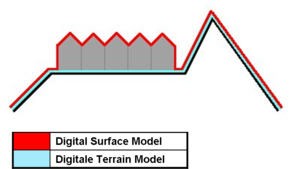




In [ ]:
# Add the files to the dataset (or change it if it is on your Google Drive)
PATH_GOOGLE_DRIVE = '/content/ISPRS_semantic_labeling_Vaihingen'

# Folder containing ground truth data
FOLDER_GT = 'gts_for_participants'

# Folder containing images
FOLDER_IMG = 'top'

# Folder containing DSM (Digital Surface Model) -> we will not use them during these 4 hours of course
FOLDER_DSM = 'dsm'

# Color palette for segmentation classes
palette = {
    0: (255, 255, 255),  # Impermeable surface (white)
    1: (0, 0, 255),      # Building (blue)
    2: (0, 255, 255),    # Low vegetation (cyan)
    3: (0, 255, 0),      # Tree (green)
    4: (255, 255, 0),    # Car (yellow)
    5: (255, 0, 0),      # Clutter (red)
    6: (0, 0, 0)         # Undefined (black)
}

# Inverted color palette (mapping RGB to class index)
invert_palette = {v: k for k, v in palette.items()}

For this section, you need to split the images into training, validation, and test sets. We will only use one image for testing. Multiple implementations are possible for this task. The goal is to create two lists (`train` and `valid`) containing the names of the images. Don't forget to set aside one image as the test image. 60% of the remaining images will be used for training, and 40% for validation.

I encourage you to read and understand Python's [*slicing*](https://zestedesavoir.com/tutoriels/582/les-slices-en-python/) methods before starting the lab.

In [ ]:
# List all ground truth images in the folder
list_of_files = os.listdir(...)
# Shuffle the list randomly (https://www.w3schools.com/python/ref_random_shuffle.asp)
...

# Extract the last image from the list as the test image : use pop function (https://www.programiz.com/python-programming/methods/list/pop)
TEST_FILE = ...

print('Name of the test img: ' + TEST_FILE)

#We count the number of images in the list (nb_file) and extract the number of images that will be included in the training set (60% of the list, variable nb_train) and the validation set (40% of the list, variable nb_valid).
nb_file = ...
nb_train = int(... * (.../100))
nb_valid = ...

print('\n')
print('Number of images in the list: ' + ...)
print('Number of images for training: ' + ...)
print('Number of images for validation: ' + ...)

#We extract lasts nb_valid images of the list list_of_files
#Slicing
list_valid = list_of_files[nb_train:...+...]
list_train = list_of_files[0:nb_train]

#We print the results
print('\n')
print('Validation list:\n' + ...)
print('Train list:\n' + ...)

Display a random image from the list on a graph. To do this, generate a random integer between 0 and the size of the list -1. Here's what it should look like:

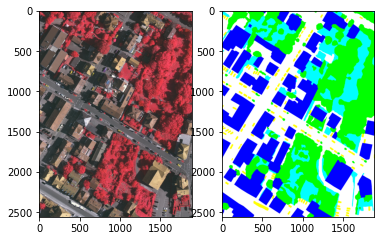

In [ ]:
#Random selection of an image index from the list
indice_img = random.randint(...)
#Path to the image and its ground truth
path_img_example = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_IMG, ...)
path_gt_example = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT, ...)
#The image is read using Matplotlib's function
img = plt.imread(...)
gt = plt.imread(...)

#Use Matplotlib for display: on the left, the color infrared image, and on the right, the ground truth.
#Feel free to search on Google for how to display two images side by side using Matplotlib/Pyplot.
...

#Display the size of the images
print('Size of the image: ' + ...)
print('Size of the ground truth: ' + ...)

Most complex part of the notebook. This step involves preparing our training and validation patches.  
Here are the parameters for the method generating the patches:  

* The path to the folder containing ground truth data  
* The path to the folder containing image data  
* The number of patches to create  
* The list with the names of the train/validation images  

The function outputs two lists with the image patches and the corresponding ground truth patches.

The idea is to randomly select 256x256 patches from our list of training images.

We have 7 classes for our ground truth data (Impervious surface, Building, Low vegetation, Tree, Car, Clutter, Undefined) and 3 bands for our image data (Blue, Green, Red). In semantic segmentation, a convolutional network expects a binary band (1 and 0) for each class. For 7 classes, we need to resize our ground truth to obtain one band per class. Currently, the dimension of our ground truth images is (x, y, 3), and we want to obtain ground truth patches with dimensions (256, 256, 7).

The image patches, however, do not change in the z dimension; they retain their 3 bands, resulting in a size of (256, 256, 3) after selection.

However, the image patches need to be normalized (values close to 0, between 0 and 1 or -1 and 1) for better classification and avoid gradient vanishing. To simplify this process in the context of this notebook, we will divide each band by 255 to obtain a value range between 0 and 1.





In [ ]:
#Method to generate training and validation patches
#Note: Be cautious with data typing, as improper handling can quickly fill up memory space.
def generate_learning_patches(path_folder_gt, path_folder_img, nb_patches, size_patches, list_with_filename, data_aug = False):
  #Counter for the number of images
  _current_nb = 0
  #Lists of images (X) and ground truth patchs (Y)
  X_res = list()
  Y_res = list()

  #Progress Bar
  with tqdm(total=nb_patches) as pbar:
    #We loop over the number of patchs requested
    while _current_nb < nb_patches:
      #Random index to select a file in the lists
      i = random.randint(0, ...)
      #We extract the paths to the files
      _gt_path = os.path.join(path_folder_gt, list_with_filename[i])
      _img_path = os.path.join(path_folder_img, list_with_filename[i])


      #Reading the ground truth and orthophoto images
      #For the ground truth, an unsigned 1-byte integer is sufficient
      _gt = tiff.imread(...).astype('uint8')
      _img = tiff.imread(...).astype('float16')

      #Randomly select coordinates within the image (be careful with the image edges!)
      _y = random.randint(0, ...)
      _x = random.randint(0, ...)

      #Select the orthophoto and ground truth patches from the images → take the previously chosen coordinate and add the patch size.
      #Indice : slicing
      res_gt = ...
      res_img = ...

      #Normalize each band by dividing by 255 to obtain values between 0 and 1 → 255 being the maximum value for each band.
      for b in range(0, ...):
        res_img[:,:,b] = ...

      #Convert the ground truth patches → check the code in the hidden functions to understand the output.
      res_gt = convert_from_color(res_gt)

      #Create a zero matrix with a depth of 7 (corresponding to the number of classes), which will be filled later.
      _tmp_gt = np.zeros( ... , dtype=np.uint8)

      #Loop through the 7 classes (0 to 6) and binarize before adding it to the corresponding band of the zero matrix.
      for i in range(0, 7):
        _tmp_gt[:, :, i] = np.where(... , ... , ...)

      res_gt = _tmp_gt

      #Add the patches to the corresponding lists and convert them using the optimal data type.
      X_res.append(...) #convert to np.float16
      Y_res.append(...) #convert to uint8 (unsigned integer using 1 byte)

      #Increment the patch count counter
      _current_nb += 1

      #Apply data augmentation methods to both the image patch and the ground truth patch.
      if data_aug:
        if randrange(100) <= 25:
          res_img, res_gt = data_augmentation(res_img, res_gt)
          X_res.append(res_img.astype(np.float16))
          Y_res.append(res_gt.astype('uint8'))
          _current_nb += 1
      pbar.update(1)

  #Return the two lists converted into NumPy arrays.
  return np.array(...), np.array(...)

**Question:** What could be the issue with this data generation approach? Have in mind the slides and the paper i presented at the begining of this course.

Below, you will find the variables to run the patch creation function.



In [ ]:
#Generation of patches for training and validation.
path_folder_gt = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT)
path_folder_img = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_IMG)
nb_patches_valid = 120
nb_patches_train = 1200 #This will take around 8 to 10 minutes to generate
size_patches = 256

X_train, Y_train = generate_learning_patches(path_folder_gt, path_folder_img, nb_patches_train, size_patches, list_train, data_aug = True)
X_valid, Y_valid = generate_learning_patches(path_folder_gt, path_folder_img, nb_patches_valid, size_patches, list_valid, data_aug = False)

# Training

## Hidden Methods

These are complex methods that you don't need to develop yourself. However, explanations of their usage are provided below for better understanding.

In [ ]:
#This is just the F1-Score, also called Dice
def dice(y_true, y_pred, smooth=1.):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Your Turn!

Now it's your turn! Carefully read the instructions before starting, and don't be afraid to experiment (even if it doesn't work!) 😉

VGG16 is used as a [*backbone*](https://stackoverflow.com/questions/59868132/what-means-backbone-in-a-neural-network) with pretrained weights from [ImageNet](https://fr.wikipedia.org/wiki/ImageNet).

**Question:** What is the activation function best suited to our problem, and why?

Complete the activation function, the number of classes, and the size of our patches.

Read the doc: https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones

In [ ]:
model = sm.Unet('vgg16', classes=7, activation=..., input_shape=(size_patches, size_patches, 3), encoder_weights='imagenet')

We will then compile the model using the Adam optimizer with a learning rate of \(1 \times 10^{-4}\), cross-entropy for the loss, and accuracy along with the [*Dice coefficient*](https://fr.wikipedia.org/wiki/Indice_de_S%C3%B8rensen-Dice) as evaluation metrics.

The training will take approximately 30-40 minutes. Complete the code and ensure it works correctly. Later, we will use the weights of a pre-trained network on our images to obtain faster results.

Feel free to check the [documentation](https://faroit.com/keras-docs/1.2.0/).

In [ ]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = [dice, 'accuracy'])

**Question:** What problem do you see with using accuracy? Is it a reliable metric for our case study? Why is it preferable to use the [*Dice coefficient*](https://fr.wikipedia.org/wiki/Indice_de_S%C3%B8rensen-Dice) or [*IoU*](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)? Check this [page](https://sci2s.ugr.es/keel/imbalanced.php) for a hint.

Here we initialize the *callbacks*:

* *Early stopping* stops the training X epochs after detecting [*overfitting*](https://fr.wikipedia.org/wiki/Surapprentissage).  
* *Reduce LR* reduces the learning rate when a metric (loss in our case) stops improving.  
* *Model Checkpoint* saves the model weights after each epoch. This allows the weights to be stored locally for predictions without retraining the model.  

In [ ]:
#We save the weights
PATH_WEIGHTS = './weights_model.keras'

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(PATH_WEIGHTS, monitor='val_loss', save_best_only=True)

Start the model training. Referring to the Keras documentation, complete the function with the training data (patches and ground truths), validation data (patches and ground truths), a batch size of 64, 100 epochs, and the list of the three previously mentioned callbacks.

In [ ]:
history = model.fit(
   x=...,
   y=...,
   batch_size=...,
   epochs=...,
   callbacks = ..., #Add callbacks here in a list format
   validation_data=... #Add tuples containing validation data, X and Y
)

**Question:** what is the objective of a validation set?

You can plot the training and validation loss if you want to check for overfitting or hyperparameters tuning.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Prediction (or classification) and evaluation

## Hidden Methods

These are complex methods that you don't need to develop yourself. However, explanations of their usage are provided below for better understanding.


In [ ]:
#Method for predicting on a patch of size patch_sz.
def predict(x, model, patch_sz=256, n_classes=7):
	img_height = x.shape[0]
	img_width = x.shape[1]
	n_channels = x.shape[2]
	# make extended img so that it contains integer number of patches
	npatches_vertical = math.ceil(img_height / patch_sz)
	npatches_horizontal = math.ceil(img_width / patch_sz)
	extended_height = patch_sz * npatches_vertical
	extended_width = patch_sz * npatches_horizontal
	ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
	# fill extended image with mirrors:
	ext_x[:img_height, :img_width, :] = x
	for i in range(img_height, extended_height):
		ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
	for j in range(img_width, extended_width):
		ext_x[:, j, :] = ext_x[:, 2 * img_width - j - 1, :]

	# now we assemble all patches in one array
	patches_list = []
	for i in range(0, npatches_vertical):
		for j in range(0, npatches_horizontal):
			x0, x1 = i * patch_sz, (i + 1) * patch_sz
			y0, y1 = j * patch_sz, (j + 1) * patch_sz
			patches_list.append(ext_x[x0:x1, y0:y1, :])
	# model.predict() needs numpy array rather than a list
	patches_array = np.asarray(patches_list)
	# predictions:
	patches_predict = model.predict(patches_array, batch_size=60)
	prediction = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
	for k in range(patches_predict.shape[0]):
		i = k // npatches_horizontal
		j = k % npatches_vertical
		x0, x1 = i * patch_sz, (i + 1) * patch_sz
		y0, y1 = j * patch_sz, (j + 1) * patch_sz
		prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
	return prediction[:img_height, :img_width, :]

#Method for obtaining a prediction from the mask containing per-band probabilities.
def get_prediction_from_mask(mask, n_classes):
	res = np.zeros((mask.shape[0], mask.shape[1]), dtype=int)

	for x in range(0, mask.shape[0]):
		for y in range(0, mask.shape[1]):
			band_nb_max = 0
			_tmp_max_value = 0
			for b in range(0, n_classes):
				if mask[x, y, b] > _tmp_max_value:
					_tmp_max_value = mask[x, y, b]
					band_nb_max = b
			res[x, y] = band_nb_max

	return res

def save_confusion_matrix(cm, classes, saveAsPng=True, pathToSave=None, normalize=True, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if saveAsPng and pathToSave:
        plt.savefig(pathToSave)
    plt.show()

## Your Turn!

Now it's your turn! Carefully read the instructions before starting, and don't be afraid to experiment (even if it doesn't work!) 😉

We want to load the model weights and predict on a randomly selected patch of 256px by 256px from our large test image.

In [ ]:
#Load the weights provided. Replace the path with your own if you have trained a new model.
model.load_weights('/content/ISPRS_semantic_labeling_Vaihingen/weights_model.keras')

Here is the image to be used for testing with the provided weights: `top_mosaic_09cm_area32` (this is the test image that was not used for training my model).  

If you have chosen to train the model yourself, select the patch chosen earlier during the preprocessing phase.  

Don't forget to normalize the patch before predicting (divide by 255)!

In [ ]:
#I won't provide further instructions here. Try to predict on a randomly selected area in the image with the size of a patch.
img_m = tiff.imread('/content/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area32.tif').astype(int)
x = randint(0, ...)
y = randint(0, ...)
pred_test = predict(... , model, patch_sz=size_patches, n_classes=...)
pred_final = get_prediction_from_mask(pred_test, 7)
res = convert_to_color(pred_final)

#Here, we want to extract the corresponding portion of the image for visual comparison. If you wish, also display the ground truth for comparison.
img_output = ...

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_output)
axarr[1].imshow(res)

We will then calculate a confusion matrix and a report containing several other metrics per class.  

**Questions:** Which classes achieve the best classification results? Which classes achieve the poorest classification results? Why?

In [ ]:
#Here, we retrieve the path to our ground truth, converting it to an integer.
gt = tiff.imread('/content/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area32.tif').astype(int)

size_x = img_m.shape[0]
size_y = img_m.shape[1]
_tmp_x = 0
_tmp_y = 0
y_true = []
y_pred = []

while _tmp_y + size_patches < size_y:
  while _tmp_x + size_patches < size_x:
    _patch = ...
    _patch_gt = ...

    pred = predict(..., model, patch_sz=size_patches, n_classes=...)
    pred = get_prediction_from_mask(pred, 7)

    _patch_gt = convert_from_color(_patch_gt)

    #Flatten allows converting a 2D matrix into a 1D list. Feel free to use print statements to better understand the transformation.
    y_pred = y_pred + list(pred.flatten())
    y_true = y_true + list(_patch_gt.flatten())

    _tmp_x += size_patches

  _tmp_x = 0
  _tmp_y += size_patches

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)
save_confusion_matrix(cm, [0,1,2,3,4])
#Display the classification report and the confusion matrix.

**Questions:** What is the issue with this code? Are we correctly evaluating the entire image? What could be improved to make it more effective?

Then, try experimenting with several parameters:

- Run trainings with a fixed number of epochs without early stopping (5, 10, 20, 30, ...) and observe the differences in classification results.  
- Run tests with a non-pretrained network (see the "Going Further" section) and compare both approaches.  
- Add the [NDVI](https://www.dronesimaging.com/wp-content/uploads/2013/05/documentation/indice%20de%20v%C3%A9g%C3%A9tation%20NDVI.pdf) to the set of bands and evaluate the predictions.  

# Solutions

## Preprocessing

In [ ]:
PATH_GOOGLE_DRIVE = '/content/ISPRS_semantic_labeling_Vaihingen'
FOLDER_GT = 'gts_for_participants'
FOLDER_IMG = 'top'
FOLDER_DSM = 'dsm'
# Color palette for segmentation classes
palette = {
    0: (255, 255, 255),  # Impermeable surface (white)
    1: (0, 0, 255),      # Building (blue)
    2: (0, 255, 255),    # Low vegetation (cyan)
    3: (0, 255, 0),      # Tree (green)
    4: (255, 255, 0),    # Car (yellow)
    5: (255, 0, 0),      # Clutter (red)
    6: (0, 0, 0)         # Undefined (black)
}
invert_palette = {v: k for k, v in palette.items()}

In [ ]:
list_of_files = os.listdir(os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT))
shuffle(list_of_files)

TEST_FILE = list_of_files.pop()

print('Name of the test img: ' + TEST_FILE)

nb_file = len(list_of_files)
nb_train = int(nb_file * (60/100))
nb_valid = nb_file - nb_train

print('\n')
print('Number of images in the list: ' + str(nb_file))
print('Number of images for training: ' + str(nb_train))
print('Number of images for validation: ' + str(nb_valid))

list_valid = list_of_files[nb_train:nb_train+nb_valid]
list_train = list_of_files[0:nb_train]

print('\n')
print('Validation list:\n' + str(list_valid))
print('Train list:\n' + str(list_train))

In [ ]:
indice_img = random.randint(0, len(list_of_files) - 1)
path_img_example = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_IMG, list_of_files[indice_img])
path_gt_example = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT, list_of_files[indice_img])
img = plt.imread(path_img_example)
gt = plt.imread(path_gt_example)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(gt)

print('Size of the image: ' + str(img.shape))
print('Size of the ground truth: ' + str(gt.shape))

In [ ]:
from random import randrange
from tqdm import tqdm

def generate_learning_patches(path_folder_gt, path_folder_img, nb_patches, size_patches, list_with_filename, data_aug=False):
  _current_nb = 0
  X_res = list()
  Y_res = list()

  with tqdm(total=nb_patches) as pbar:
    while _current_nb < nb_patches:
      i = random.randint(0, len(list_with_filename) - 1)
      _gt_path = os.path.join(path_folder_gt, list_with_filename[i])
      _img_path = os.path.join(path_folder_img, list_with_filename[i])

      _gt = tiff.imread(_gt_path).astype('uint8')
      _img = tiff.imread(_img_path).astype('float16')

      _y = random.randint(0, _gt.shape[0] - size_patches)
      _x = random.randint(0, _gt.shape[1] - size_patches)

      res_gt = _gt[_y:(_y + size_patches), _x:(_x + size_patches)]
      res_img = _img[_y:(_y + size_patches), _x:(_x + size_patches)]

      for b in range(0, res_img.shape[2]):
        res_img[:,:,b] = res_img[:,:,b]/255

      res_gt = convert_from_color(res_gt)

      _tmp_gt = np.zeros((res_gt.shape[0], res_gt.shape[1], 7), dtype=np.uint8)

      for i in range(0, 7):
        _tmp_gt[:, :, i] = np.where(res_gt == i, 1, 0)

      res_gt = _tmp_gt

      X_res.append(res_img.astype(np.float16))
      Y_res.append(res_gt.astype('uint8'))

      _current_nb += 1

      if data_aug:
        if randrange(100) <= 25:
          res_img, res_gt = data_augmentation(res_img, res_gt)
          X_res.append(res_img.astype(np.float16))
          Y_res.append(res_gt.astype('uint8'))
          _current_nb += 1

      pbar.update(1)

  return np.array(X_res), np.array(Y_res)

In [ ]:
path_folder_gt = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT)
path_folder_img = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_IMG)
nb_patches_valid = 100
nb_patches_train = 1200
size_patches = 256

X_train, Y_train = generate_learning_patches(path_folder_gt, path_folder_img, nb_patches_train, size_patches, list_train, data_aug=True)
X_valid, Y_valid = generate_learning_patches(path_folder_gt, path_folder_img, nb_patches_valid, size_patches, list_train, data_aug=False)

## Training

In [ ]:
model = sm.Unet('vgg16', classes=7, activation='softmax', input_shape=(size_patches, size_patches, 3), encoder_weights='imagenet')

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
PATH_WEIGHTS = 'weights_model.keras'

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(PATH_WEIGHTS, monitor='val_loss', save_best_only=True)

In [ ]:
history = model.fit(
   x=X_train,
   y=Y_train,
   batch_size=16,
   epochs=100,
   callbacks = [early_stopping, reduce_lr, model_checkpoint],
   validation_data=(X_valid, Y_valid)
)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## Prediction (or classification) and evaluation

In [ ]:
model.load_weights('/content/weights_model.keras')

In [ ]:
img_m = tiff.imread('/content/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area32.tif').astype(int)
gt = tiff.imread('/content/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area32.tif').astype(int)
dsm = tiff.imread('/content/ISPRS_semantic_labeling_Vaihingen/dsm/dsm_09cm_matching_area32.tif').astype(int)

x = randint(0, img_m.shape[0] - size_patches - 1)
y = randint(0, img_m.shape[1] - size_patches - 1)
pred_test = predict(img_m[x:x+size_patches, y:y+size_patches, :]/255, model, patch_sz=size_patches, n_classes=7)
pred_final = get_prediction_from_mask(pred_test, 7)
res = convert_to_color(pred_final)
img_output = img_m[x:x+size_patches, y:y+size_patches, :]
gt_output = gt[x:x+size_patches, y:y+size_patches, :]
dsm_output = dsm[x:x+size_patches, y:y+size_patches]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_output)
axarr[0,1].imshow(res)
axarr[1,0].imshow(dsm_output)
axarr[1,1].imshow(gt_output)

palette = {0 : (255, 255, 255), # Surface imperméable (blanc)
           1 : (0, 0, 255),     # Batiment (bleus)
           2 : (0, 255, 255),   # Végétation basse (cyan)
           3 : (0, 255, 0),     # Arbre (vert)
           4 : (255, 255, 0),   # Voiture (jaune)
           5 : (255, 0, 0),     # Clutter (rouge)
           6 : (0, 0, 0)}       # Indéfini (noir)

In [ ]:
gt = tiff.imread('/content/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area32.tif').astype(int)
array = np.unique(convert_from_color(gt))
print(array)

size_x = img_m.shape[0]
size_y = img_m.shape[1]
_tmp_x = 0
_tmp_y = 0
y_true = []
y_pred = []

while _tmp_y + size_patches < size_y:
  while _tmp_x + size_patches < size_x:
    _patch = img_m[_tmp_x:(_tmp_x + size_patches), _tmp_y:(_tmp_y+size_patches)]
    _patch_gt = gt[_tmp_x:(_tmp_x + size_patches), _tmp_y:(_tmp_y+size_patches)]

    pred = predict(_patch/255, model, patch_sz=size_patches, n_classes=7)
    pred = get_prediction_from_mask(pred, 7)

    _patch_gt = convert_from_color(_patch_gt)

    y_pred = y_pred + list(pred.flatten())
    y_true = y_true + list(_patch_gt.flatten())

    _tmp_x += size_patches

  _tmp_x = 0
  _tmp_y += size_patches

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)
save_confusion_matrix(cm, [0,1,2,3,4])
print(cr)